In [1]:
# Import libraries
import psycopg2
import getpass
import matplotlib.pyplot as plt
import numpy as np
import os.path
import time

In [2]:
# load the data
_data = np.load('res/admission.npy', allow_pickle=True).tolist()
adm_labels = _data['adm_labels']
all_adm = _data['all_adm']
first_adm = _data['first_adm']
adult_first_adm = _data['adult_first_adm']
print("Loaded!")

Loaded!


In [3]:
# Create a database connection
user = 'postgres'
host = 'localhost'
port = '5433'
dbname = 'mimic'
schema = 'mimiciii'

In [4]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path TO {}'.format(schema))
con.commit()
print("Connected!")

Password: ··········


Connected!


In [5]:
start = time.time()

# Select serum FiO2 measurements
query = \
"""
SELECT subject_id, hadm_id, hadm_id, itemid, charttime, valuenum, valueuom
FROM labevents
WHERE itemid = 50816 OR itemid = 223835 OR itemid = 3420 OR itemid = 3422 OR itemid = 190
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
fi_oxygen = np.array(data)

end = time.time()

# Print run time
print("This query took {} seconds".format(round((end-start),2)))

This query took 7.22 seconds


In [6]:
# Select the different units
query = \
"""
SELECT DISTINCT(valueuom)
FROM labevents
WHERE itemid = 50816 OR itemid = 223835 OR itemid = 3420 OR itemid = 3422 OR itemid = 190
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
units = np.array(data)

# Display the units
print("Units:")
print(units)

Units:
[[None]
 ['%']]


In [7]:
# Check how many serum FiO2 measurements are in the data set
print("No. of FiO2 measurements: {}".format(np.shape(fi_oxygen)[0]))
print("No. of 'None' values: {} ({}%)".format(sum(x is None for x in fi_oxygen[:,5]), round(sum(x is None for x in fi_oxygen[:,5])/np.shape(fi_oxygen)[0],4)))

No. of FiO2 measurements: 127960
No. of 'None' values: 144 (0.0011%)


In [8]:
print("Shape of fi_oxygen before removing None values: {}".format(np.shape(fi_oxygen)))

# Remove None values
fi_oxygen = fi_oxygen[~np.isnan(fi_oxygen[:,5].astype(float))]

print("Shape of fi_oxygen after removing None values: {}".format(np.shape(fi_oxygen)))

Shape of fi_oxygen before removing None values: (127960, 7)
Shape of fi_oxygen after removing None values: (127816, 7)


In [9]:
# Select data for hospital admission ID 145834 only
fio2 = fi_oxygen[fi_oxygen[:,1]==145834]

In [10]:
# Sort measurements by time
fio2 = fio2[fio2[:,4].argsort()]
fio2[:,4] = fio2[:,4] - adult_first_adm[:,-1][adult_first_adm[:,1]==145834] # convert raw times to time since admission
for i in range(len(fio2[:,4])):
    fio2[:,4][i] = fio2[:,4][i].total_seconds()/(60*60)

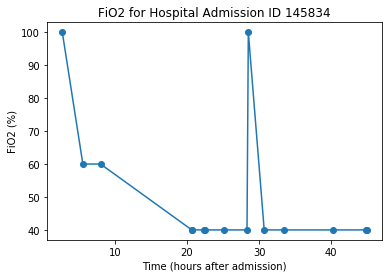

In [11]:
# Plot FiO2 data for hospital admission ID 145834
hrs = 48 # select how many hours post admission to display
plt.plot(fio2[:,4][fio2[:,4]<=hrs], fio2[:,5][fio2[:,4]<=hrs], marker="o")
plt.xlabel('Time (hours after admission)')
plt.ylabel('FiO2 (%)')
plt.title('FiO2 for Hospital Admission ID 145834')
plt.show()

In [12]:
print("No. of measurements in first {} hours: {}".format(hrs,len(fio2[:,4][fio2[:,4]<=hrs])))
print("Total no. of measurements: {}".format(len(fio2[:,4])))

No. of measurements in first 48 hours: 15
Total no. of measurements: 26


In [13]:
# Get mean FiO2 for each hour
processed_fio2 = np.zeros((hrs,2))
for i in range(hrs):
    fio2_values = fio2[:,5][np.logical_and(fio2[:,4]>=i, fio2[:,4]<(i+1))]
    x = 1
    while len(fio2_values) == 0:
        fio2_values = fio2[:,5][np.logical_and(fio2[:,4]>=(i-x), fio2[:,4]<(i+1+x))]
        x+=1
    mean_fio2 = np.mean(fio2_values)
    processed_fio2[i,0] = i+1
    processed_fio2[i,1] = mean_fio2

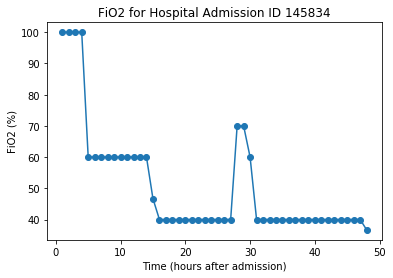

In [14]:
# Plot the processed FiO2 data for hospital admission ID 145834
plt.plot(processed_fio2[:,0], processed_fio2[:,1], marker="o")
plt.xlabel('Time (hours after admission)')
plt.ylabel('FiO2 (%)')
plt.title('FiO2 for Hospital Admission ID 145834')
plt.show()

In [15]:
# Initialise a 3D numpy array for 24 hour measurements
hrs = 48
m = len(adult_first_adm) # number of patients
fio2_24h = np.zeros((m, hrs+1, 1))

In [16]:
# Create processed 24 hour FiO2 time series for every patient
start = time.time()

for i in range(m):
    
    # Define hospital admission ID number
    admission_id = adult_first_adm[i,1]
    
    # Select data for hospital admission ID
    fio2 = fi_oxygen[fi_oxygen[:,1]==admission_id]
    
    # Account for patients with no FiO2 measurements
    if len(fio2) == 0:
        processed_fio2 = np.zeros((hrs,1))
        
    else:
    
        # Sort measurements by time
        admit_time = adult_first_adm[i,-1]
        fio2 = fio2[fio2[:,4].argsort()]
        fio2[:,4] = fio2[:,4] - admit_time # convert raw times to time since admission
        for j in range(len(fio2[:,4])):
            fio2[:,4][j] = fio2[:,4][j].total_seconds()/(60*60)
    
        # Get mean FiO2 for each hour
        processed_fio2 = np.zeros((hrs,1))
        for k in range(hrs):
            fio2_values = fio2[:,5][np.logical_and(fio2[:,4]>=k, fio2[:,4]<(k+1))]
            x = 1
            while len(fio2_values) == 0:
                fio2_values = fio2[:,5][np.logical_and(fio2[:,4]>=(k-x), fio2[:,4]<(k+1+x))]
                x+=1
            mean_fio2 = np.mean(fio2_values)
            processed_fio2[k] = mean_fio2
    
    # Store in fio2_24h
    fio2_24h[i,0,:] = admission_id
    fio2_24h[i,1:,:] = processed_fio2
    
    # Print progress
    if (i+1) % 1000 == 0:
        print("{}% complete ({}/{})".format(round((i+1)/m*100,2), i+1, m))

end = time.time()

# Evaluate run time
print("This took {} minutes".format(round((end-start)/60,2)))

2.59% complete (1000/38549)
5.19% complete (2000/38549)
7.78% complete (3000/38549)


KeyboardInterrupt: 

In [21]:
fio2_labels = ["subject_id", "hadm_id", "hadm_id", "itemid", "charttime", "valuenum", "valueuom"]

# Save to fio2.npy
if not os.path.exists('./res'):
    os.makedirs('./res')

tosave = {'fio2_labels': fio2_labels, 'fi_oxygen': fi_oxygen, 'fio2_24h': fio2_24h}
np.save('res/fio2.npy',tosave)
print("Saved!")

Saved!
